In [1]:
import numpy as np
import ticktack
from ticktack import fitting
import matplotlib.pyplot as plt

In [2]:
sf = fitting.SingleFitter("Brehm21", "Brehm21")
sf.load_data("miyake12.csv")
sf.compile_production_model(model="control_points")

INFO[2022-03-04 12:08:52,716]: Unable to initialize backend 'tpu_driver': Not found: Unable to find driver in registry given worker: 
INFO[2022-03-04 12:08:52,717]: Unable to initialize backend 'gpu': Not found: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
INFO[2022-03-04 12:08:52,718]: Unable to initialize backend 'tpu': Invalid argument: TpuPlatform is not available.
WARNING[2022-03-04 12:08:52,718]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
params = np.ones(sf.control_points_time.shape)
low = np.zeros(sf.control_points_time.shape)
high = np.ones(sf.control_points_time.shape) * 100
sf.control_points_time_fine = np.linspace(sf.start, sf.end, int((sf.end - sf.start) * 108))

In [4]:
%%timeit
sf.log_joint_likelihood(params, low, high)

59.3 ms ± 1.39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
%%timeit
sf.interp_gp(sf.control_points_time_fine, params)

239 µs ± 9.25 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [6]:
sf.log_joint_likelihood(params, low, high)

DeviceArray(-124996.9048177, dtype=float64)

In [7]:
sf.log_likelihood_gp(params)

DeviceArray(-29.40287991, dtype=float64)

In [29]:
import jax.numpy as jnp
from jax import jit, grad, hessian, jacrev
import jax
from tinygp import kernels, GaussianProcess

In [9]:
sf2 = fitting.SingleFitter("Brehm21", "Brehm21")
sf2.load_data("miyake12.csv")
sf2.compile_production_model(model="control_points")

In [10]:
def build_gp(*args):
    params = jnp.array(list(args)).reshape(-1)
    kernel = kernels.Matern32(1)
    return GaussianProcess(kernel, sf2.control_points_time, mean=params[0])

@jit
def interp_gp(tval, *args):
    tval = tval.reshape(-1)
    gp = build_gp(*args)
    params = jnp.array(list(args)).reshape(-1)
    return gp.condition(params, tval)[1].loc

@jit
def log_likelihood_gp(params):
    kernel = kernels.Matern32(1)
    gp = GaussianProcess(kernel, sf2.control_points_time, mean=params[0])
    return gp.log_probability(params)

@jit
def log_joint_likelihood_gp(params, low_bounds, up_bounds):
    lp = jnp.any((params < low_bounds) | (params > up_bounds)) * -jnp.inf
    return sf2.log_likelihood(params=params) + log_likelihood_gp(params) + lp

sf2.production = interp_gp
sf2.control_points_time_fine = jnp.linspace(sf2.start, sf2.end, int((sf2.end - sf2.start) * 108))
sf2.control_points_time_fine.shape

(2916,)

In [18]:
random = np.random.randn(sf2.control_points_time.size)

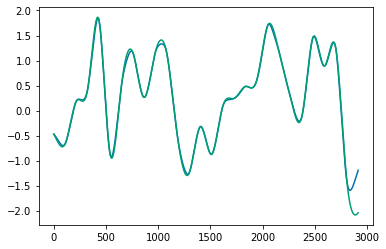

In [22]:
plt.plot(interp_gp(sf2.control_points_time_fine, random))
plt.plot(sf.interp_gp(sf2.control_points_time_fine, random))

In [24]:
@jit
def grad_log_joint_likelihood_gp(params, low_bounds, up_bounds):
    return grad(log_joint_likelihood_gp)(params, low_bounds, up_bounds)

In [30]:
@jit
def hess_log_joint_likelihood_gp(params, low_bounds, up_bounds):
    return jacrev(jacrev(log_joint_likelihood_gp))(params, low_bounds, up_bounds)

In [25]:
%%timeit
grad_log_joint_likelihood_gp(params, low, high)

1.34 s ± 9.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
hess_log_joint_likelihood_gp(params, low, high)

In [11]:
%%timeit
interp_gp(sf2.control_points_time_fine, params)
# plt.plot(sf2.control_points_time_fine, interp_gp(sf2.control_points_time_fine, params))

650 µs ± 65.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%%timeit
# log_joint_likelihood_gp(params)
log_joint_likelihood_gp(params, low, high)

23.2 ms ± 1.89 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
log_joint_likelihood_gp(params, low, high)

DeviceArray(-124980.6345283, dtype=float64)

In [14]:
log_likelihood_gp(params)

DeviceArray(-21.15613452, dtype=float64)